# 0. Noise removal with autoencoders

In this notebook, we attempt to remove noise to obtain clean images using autoencoders.

The surfaces of many particles are extremely rough. As a result, various imaging techniques struggle to obtain clean images due to a common interference phenomenon called speckle. 

Speckle is a granular interference that inherent and degrades the quality of the active radar, synthetic aperture radar (SAR), medical ultrasound, and optical coherence tomography images. This unwanted modification of the ground truth makes the recorded data noisy.  

In this example, we remove the speckle using an autoencoder.



In [ ]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.8.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [ ]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [ ]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

OK
75 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 75 not upgraded.
Need to get 12.0 MB of archives.
After this operation, 28.6 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.40.0_amd64.deb ...
Unpacking gcsfuse (0.40.0) ...
Setting up gcsfuse (0.40.0) ...
2022/03/04 14:39:24.554953 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /content/sciml-workshop-data
2022/03/04 14:39:24.574853 Opening GCS connection...
2022/03/04 14:39:25.074905 Mounting file system "sciml-workshop"...
2022/03/04 14:39:25.105450 File system has been successfully mounted.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  66763      0 --:--:-- --:--:-- --:--:-- 68567




Updated property [core/project].


---

# 1. Load the dataset

### Read raw data

The data is stored in 'Physics/speckles.npz', containing 25484, gray-scale, 64 × 64 images. We will use 80% of images to train neural networks and the rest of them to evaluate the neural networks. The details of the data can be found in https://nbviewer.org/github/DeepLearningForPhysicsResearchBook/deep-learning-physics/blob/main/Exercise_17_1.ipynb.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
f = np.load(join(data_path, 'Physics/speckles.npz'))

noised_img = f['speckle_images']
clean_img = f['target_images']

max_pixel = np.max(noised_img, axis=(1, 2, 3), keepdims=True)

noised_img = noised_img/max_pixel
clean_img = clean_img/max_pixel

n_train = int(len(noised_img)*0.8)

x_train = noised_img[:n_train]
y_train = clean_img[:n_train]


x_test = noised_img[n_train:]
y_test = clean_img[n_train:]
```
    
</p>
</details>

In [ ]:
f = np.load(join(data_path, 'Physics/speckles.npz'))

noised_img = f['speckle_images']
clean_img = f['target_images']

max_pixel = np.max(noised_img, axis=(1, 2, 3), keepdims=True)

noised_img = noised_img/max_pixel
clean_img = clean_img/max_pixel

n_train = int(len(noised_img)*0.8)

x_train = noised_img[:n_train]
y_train = clean_img[:n_train]


x_test = noised_img[n_train:]
y_test = clean_img[n_train:]

In [ ]:
# define image size
IMG_HEIGHT = 64
IMG_WIDTH = 64
N_CHANNELS = 1
N_CLASSES = 2


# print
print("Number of training data: %d" % len(x_train))
print("Number of test data: %d" % len(x_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))

Number of training data: 20387
Number of test data: 5097
Image pixels: (64, 64)
Number of channels: 1


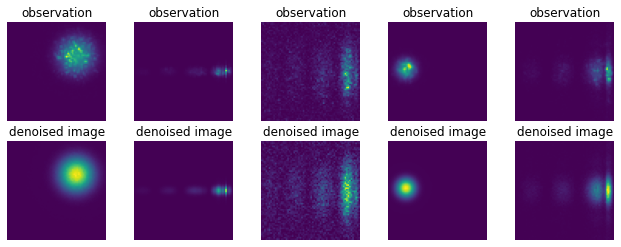

In [ ]:
fig, axes = plt.subplots(2, 5, figsize = (11, 4))
for i in range(5):
    rnd_idx = np.random.choice(len(x_train), 1)[0]
    axes[0][i].imshow(x_train[rnd_idx].reshape(64, 64))
    axes[0][i].set_title('observation')
    axes[0][i].axis('off')
    axes[1][i].imshow(y_train[rnd_idx].reshape(64, 64))
    axes[1][i].set_title('denoised image')
    axes[1][i].axis('off')

---

# 2. Build the network

The task is to build and train a convolutional autoencoder to remove speckle in images

### The encoder

The encoder contains three convolutional layers, an input layer with size 64$\times$64$\times$1 and one dense layer with size 128:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the encoder
image_input = keras.Input(shape=(64, 64, 1))
#x = layers.Flatten()(image_input)
x = layers.Conv2D(32, 4, 2, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
latent_output = layers.Dense(128)(x)
encoder_AE = keras.Model(image_input, latent_output)
encoder_AE.summary()
```
    
</p>
</details>

In [ ]:
# build the encoder
image_input = keras.Input(shape=(64, 64, 1))
#x = layers.Flatten()(image_input)
x = layers.Conv2D(32, 4, 2, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
latent_output = layers.Dense(128)(x)
encoder_AE = keras.Model(image_input, latent_output)
encoder_AE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        544       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        16416     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                             

### The decoder

The decoder contains three transposed convolutional layers and one dense layer that are reciprocal to those of the encoders and one convolutional layer, outputing denoised images with the same size as the input images:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the decoder
latent_input = keras.Input(shape=(128))
x = layers.Dense(4096)(latent_input)
x = layers.Reshape((8, 8, 64), input_shape=(4096,))(x)
x = layers.Conv2DTranspose(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
image_output = layers.Conv2D(1, 3, padding = 'same')(x)

decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()
```
    
</p>
</details>

In [ ]:
# build the decoder
latent_input = keras.Input(shape=(128))
x = layers.Dense(4096)(latent_input)
x = layers.Reshape((8, 8, 64), input_shape=(4096,))(x)
x = layers.Conv2DTranspose(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
image_output = layers.Conv2D(1, 3, padding = 'same')(x)

decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              528384    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       65600     
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 16, 16, 64)        0   

### The autoencoder

Joining up the encoder and the decoder, we obtain the AE network:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the AE
image_input = keras.Input(shape=(64, 64, 1))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
```
    
</p>
</details>

In [ ]:
# build the AE
image_input = keras.Input(shape=(64, 64, 1))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 model (Functional)          (None, 128)               574720    
                                                                 
 model_1 (Functional)        (None, 64, 64, 1)         644001    
                                                                 
Total params: 1,218,721
Trainable params: 1,218,209
Non-trainable params: 512
_________________________________________________________________


### Train the autoencoder

In [ ]:
# train the AE
ae_model.fit(x_train, y_train, epochs=10, batch_size=64)
            

Epoch 1/10
319/319 [==============================] - 23s 38ms/step - loss: 0.0155 - mse: 0.0155
Epoch 2/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0033 - mse: 0.0033
Epoch 3/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0021 - mse: 0.0021
Epoch 4/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0017 - mse: 0.0017
Epoch 5/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0015 - mse: 0.0015
Epoch 6/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0013 - mse: 0.0013
Epoch 7/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0012 - mse: 0.0012
Epoch 8/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0011 - mse: 0.0011
Epoch 9/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0011 - mse: 0.0011
Epoch 10/10
319/319 [==============================] - 12s 37ms/step - loss: 0.0011 - mse: 0.0011


---

# 3. Analyse results 

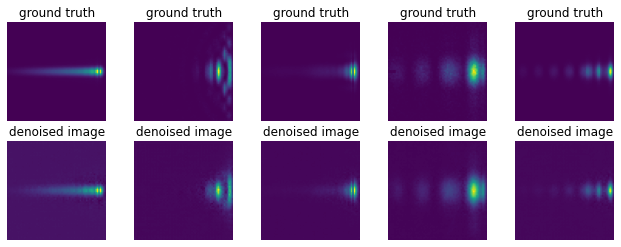

In [ ]:
y_denoised = ae_model.predict(x_test)


fig, axes = plt.subplots(3, 5, figsize = (11, 6))
for i in range(5):
    rnd_idx = np.random.choice(len(x_test), 1)[0]
    axes[0][i].imshow(x_test[rnd_idx].reshape(64, 64))
    axes[0][i].set_title('observation')
    axes[0][i].axis('off')
    axes[1][i].imshow(y_test[rnd_idx].reshape(64, 64))
    axes[1][i].set_title('ground truth')
    axes[1][i].axis('off')
    axes[2][i].imshow(y_denoised[rnd_idx].reshape(64, 64))
    axes[2][i].set_title('denoised by AE')
    axes[2][i].axis('off')

---

# 4. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)); 
* Change the architeture and activation functions of neural networks to improve the performance
* Add noise to input layer to make the network more robust to noise